In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *

PCA = True
NN_METHOD = False
# np.random.seed(10)

## Data Loading

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("/home/zewzhang/Course/ML/ML_course/projects/project1/data/dataset_to_release", sub_sample=False)

## Data preprocessing

Before feeding data into the regressor, we preprocessed the data through the following pipeline:
- **Data dropping**: We dropped the rows and columns which had more than 50%~70% (possible to tune) missing values.

- **Missing value imputation**: We imputed missing values in the dataset using the mean of the column if the feature is not categorical, otherwise we imputed the missing values using the majority of categorical features in that column.

- **One-hot encoding**: We one-hot encoded the categorical features in the dataset.

- **Feature scaling**: We scaled the features in the dataset in terms of the regression model we used. For logistics/hinge regression, we used standard scaler to scale the features. For neural network, we used min-max scaler to scale the features.

- **Outlier detection**: We detected outliers in the dataset using Z-score. We removed the outliers from the dataset for non-neural network models. For neural network, we did not remove the outliers.

- **Feature selection**: We selected the features using PCA for non-neural network models. For neural network, we did not do feature selection.

In [4]:
def data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold):
    """Data processing for training and testing data"""
    
    x_train_processed = x_train.copy()
    y_train_processed = y_train.copy()

    # transform y to 0-1 encoding
    y_train_processed = process_y(y_train_processed)

    # Remove rows with too many nans
    x_train_processed, y_train_processed, row_indices = drop_rows(x_train_processed, y_train_processed, row_nan) # 0.55 remains 6101 rows
    # Remove features with too many nans
    x_train_processed, nan_indices = drop_features(x_train_processed, feature_nan) # 0.5 remains 174 features
    x_test_processed = x_test[:, nan_indices].copy()
    threshold_cat = 10

    # get categorical feature indices
    cat_indices = check_categorical(x_train_processed, threshold_cat)
    # handling remaining nans
    x_train_processed = fillna(x_train_processed, cat_indices)
    x_test_processed = fillna(x_test_processed, cat_indices)

    # One hot encoding for categorical features
    x_train_processed, x_test_processed = one_hot_encoding(x_train_processed, x_test_processed, cat_indices)

    if NN_METHOD:
        # normalize data if using NN
        x_train_processed, train_max, train_min = normalization(x_train_processed)
        x_test_processed, _, _ = normalization(x_test_processed, train_max, train_min)
        # x_train_processed, train_mean, train_std = standardize(x_train_processed)
        # x_test_processed = (x_test_processed - train_mean) / train_std
    else:
        # standardize data and remove outliers if using other regression methods
        x_train_processed, train_mean, train_std = standardize(x_train_processed)
        x_test_processed = (x_test_processed - train_mean) / train_std
        # Remove outliers
        x_train_processed, y_train_processed = z_outlier_removal(x_train_processed, y_train_processed, z_threshold, feature_threshold)

    if PCA:
        x_train_processed, eig_vec, _, weight = pca(x_train_processed, 200)
        x_train_processed = np.real(x_train_processed)
        x_test_processed = np.real(x_test_processed @ eig_vec)
        plt.figure(figsize=(5, 2.75))
        plt.plot(np.cumsum(weight))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance')
        plt.savefig('pca.png', dpi=300, bbox_inches='tight')

    return x_train_processed, y_train_processed, x_test_processed

Process the raw datasets with predefined various threshold values.

/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


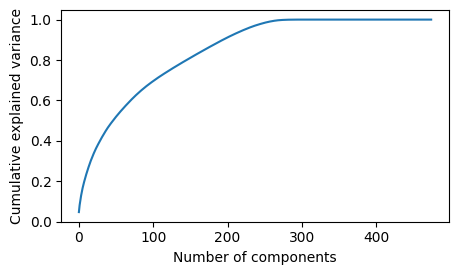

In [5]:
# threshold percentage used to remove rows (samples) with too many NaN
row_nan = 0.5 
# threshold percentage used to remove features with too many NaN
feature_nan = 0.4 
# threshold of z score used to remove outliers
z_threshold = 2  
# threshold of percentage of outlier features used to remove samples
feature_threshold = 0.3 
x_train_processed, y_train_processed, x_test_processed = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)

## Hyperparameter tuning and Model Training

We applied random search to three models: regularized logistic regression, hinge regression, and ridge regression. We tuned the hyperparameters of the models using the following ranges: $\lambda \in [0.0001, 5], \gamma \in [0.0001, 5] $. For ridge model, only $\gamma $ will be optimized. We used 5-fold cross validation and the average best f1 scores to evaluate the performance of the models. 

The best f1 score is the highest scores among all the prediction thresholds. The prediction threshold is used for converting the predicted probabilities to predicted labels. For regularized logistic regression and ridge regression model, we gave the threshold a range of [0.1, 0.9] with step size 0.1. For hinge regression model, we gave the threshold a range of [0.1, 3] with step size 0.1. The best threshold is the one that gives the highest f1 score. 

In [6]:
def random_search(params, reg_name, objective_func):
    """Random search for hyperparameter tuning"""
    best_params = None
    best_score = 0
    for i in range(40):
        param = {k: np.random.uniform(v[0], v[1]) for k, v in params.copy().items()}
        score = objective_func(param, reg_name)
        if score > best_score:
            best_score = score
            best_params = param
        print("Iteration {}: parameters = {}, score = {}".format(i, param, score))
        print("Best score = {} and best params = {}".format(best_score, best_params))
    return best_params, best_score

def cross_validation(model, x, y, k_fold=10, nn_init=None):
    """cross-validation for regression models"""
    sub_x, sub_y = split_cross_validation(x, y, k_fold)
    f1s = []
    accs = []
    losses = []
    thresholds = []

    for i in range(k_fold):
        if NN_METHOD:
            nn_init.network = nn_init.initialize_network()
        sub_cur_x, sub_cur_y = sub_x.copy(), sub_y.copy()
        x_val, y_val = sub_cur_x.pop(i), sub_cur_y.pop(i)
        x_train, y_train = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
        # data augmentation for unbalanced data
        x_train, y_train = data_augmentation(x_train, y_train)
        w, loss, best_f1, best_acc, best_threshold = model(x_train, y_train, x_val, y_val)
        f1s.append(best_f1)
        accs.append(best_acc)
        losses.append(loss)
        thresholds.append(best_threshold)

    return f1s, accs, losses, thresholds

def object_function(params, x_train, y_train, reg_name, max_iters=500, n_pat=20):
    """Objective function for random search"""
    if reg_name == 'reg_log':
        lamb = params['lamb']
        gamma = params['gamma']
        # use lambda to define the model, modify the arguments of the function
        model = lambda x_train, y_train, x_val, y_val : reg_logistic_regression_var(y_train, add_bias(x_train), y_val, add_bias(x_val),
                                                                                 lambda_=lamb, initial_w=np.random.randn(x_train.shape[1]+1) * 0.01, 
                                                                                 max_iters=max_iters, gamma=gamma, n_pat=n_pat)
    elif reg_name == 'hinge':
        lamb = params['lamb']
        gamma = params['gamma']
        model = lambda x_train, y_train, x_val, y_val : hinge_regression(y_train, x_train, y_val, x_val,
                                                                                 lambda_=lamb, initial_w=np.random.randn(x_train.shape[1]) * 0.01, 
                                                                                 max_iters=max_iters, gamma=gamma, n_pat=n_pat)
    elif reg_name == 'ridge':
        lamb = params['lamb']
        model = lambda x_train, y_train, x_val, y_val : ridge_regression_var(y_train, add_bias(x_train), y_val, add_bias(x_val), lambda_=lamb)

    # cross-validation
    f1s, accs, losses, thresholds = cross_validation(model, x_train, y_train, k_fold=5)

    return np.mean(f1s)

obj_func = lambda params, reg_name: object_function(params, x_train_processed, y_train_processed, reg_name)
# if dict variable not exist, instantiate it
if 'best_params' not in locals():
    best_params = {}

#### Hinge regression:

In [7]:
params = {'lamb': [0.0001, 1], 'gamma': [0.0001, 1]}
best_params["hinge"], best_f1 = random_search(params, "hinge", obj_func)
print("Best params: ", best_params)
print("Best f1 score: ", best_f1)

Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Iteration 0: parameters = {'lamb': 0.7611503766666072, 'gamma': 0.9601351146590222}, score = 0.3128542494010587
Best score = 0.3128542494010587 and best params = {'lamb': 0.7611503766666072, 'gamma': 0.9601351146590222}
Early stopping at iteration  30
Early stopping at iteration  30
Early stopping at iteration  30
Early stopping at iteration  30
Early stopping at iteration  34
Iteration 1: parameters = {'lamb': 0.44596340446885524, 'gamma': 0.33092608423170894}, score = 0.4128392561633397
Best score = 0.4128392561633397 and best params = {'lamb': 0.44596340446885524, 'gamma': 0.33092608423170894}
Early stopping at iteration  30
Early stopping at iteration  42
Early stopping at iteration  26
Early stopping at iteration  58
Early stopping at iteration  22
Iteration 2: parameters = {'lamb': 0.9235427206618, 'gamma': 0.2423911263720

#### Regularized logistic regression:

In [8]:
params = {'lamb': [0.0001, 1], 'gamma': [0.0001, 1]}
best_params["reg_log"], best_f1 = random_search(params, "reg_log", obj_func)
print("Best params: ", best_params)
print("Best f1 score: ", best_f1)

/home/zewzhang/Course/ML/Project/ML_proj/implementations.py:252: RuntimeWarning: divide by zero encountered in log
  total_loss = -np.sum(y * np.log(pred_probs) + (1 - y) * np.log(1 - pred_probs))
/home/zewzhang/Course/ML/Project/ML_proj/implementations.py:252: RuntimeWarning: invalid value encountered in multiply
  total_loss = -np.sum(y * np.log(pred_probs) + (1 - y) * np.log(1 - pred_probs))


Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  21
Iteration 0: parameters = {'lamb': 0.6078205720195246, 'gamma': 0.9821281395045856}, score = 0.333810531520526
Best score = 0.333810531520526 and best params = {'lamb': 0.6078205720195246, 'gamma': 0.9821281395045856}
Early stopping at iteration  21
Early stopping at iteration  21
Early stopping at iteration  53
Early stopping at iteration  21
Early stopping at iteration  21
Iteration 1: parameters = {'lamb': 0.48898196890452494, 'gamma': 0.577167572514333}, score = 0.35681151271286576
Best score = 0.35681151271286576 and best params = {'lamb': 0.48898196890452494, 'gamma': 0.577167572514333}
Early stopping at iteration  32
Early stopping at iteration  30
Early stopping at iteration  34
Early stopping at iteration  30
Early stopping at iteration  46
Iteration 2: parameters = {'lamb': 0.29056192424104366, 'gamma': 0.6419816626670

#### Ridge regression:

In [32]:
params = {'lamb': [0.0001, 1]}
best_params["ridge"], best_f1 = random_search(params, "ridge", obj_func)
print("Best params: ", best_params)
print("Best f1 score: ", best_f1)

Iteration 0: parameters = {'lamb': 0.35487461834360234}, score = 0.25371711609678166
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration 1: parameters = {'lamb': 0.9476670323651742}, score = 0.25275194275948476
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration 2: parameters = {'lamb': 0.44942581362133044}, score = 0.25231407548485596
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration 3: parameters = {'lamb': 0.1351556811692372}, score = 0.2529275850171215
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration 4: parameters = {'lamb': 0.6593006967463579}, score = 0.25212796867685294
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration 5: parameters = {'lamb': 0.32061806960829475}, score = 0.2522366355796063
Best score = 0.25371711609678166 and best params = {'lamb': 0.35487461834360234}
Iteration

All the optimal hyperparameters  are saved and can be used for the final training later.

### Neural network:

To improve the prediction accuracy, we also implemented neural network model. This is because neural network can capture the non-linear relationship between the features and the target. The network structure we used is [Input x 400 x 200 x 100 x 4 x 1] with Relu activation function in hidden layers and sigmoid activation function in the output layer. We used binary cross entropy loss function to regress the binary classification output. 

#### Network Training

We split the training data into training set and validation set with ratio 0.8:0.2. We trained the network with 100 epochs and batch size 4062 with learning rate 0.05. We used early stopping to prevent overfitting by checking the f1 score on the validation set. The patience is set to 10 epochs. We saved the model with the best validation loss.

In [29]:
NN_METHOD = True
x_train_processed, y_train_processed, x_test_processed = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)

In [10]:
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.8)
x_t, y_t = data_augmentation(x_t, y_t)
# initilize the neural network
nn = NeuralNetwork([np.shape(x_t)[1], 400, 200, 100, 4, 1],'sigmoid','bce')
# train the neural network
nn_trained, loss, f1s_val, accs_val, thre_val = nn.train(x_t, y_t, x_v, y_v, learning_rate=0.05, epochs=1000, batch_size=4062)


Epoch: 0 Loss: 0.6282652493074876 Validation F1: [0.16515542525743276, 0.16515542525743276, 0.1749826588665083, 0.2188731532616379, 0.2730274924900228, 0.2690459393614979, 0.13980024562100102, 0.0, 0.0] Validation Acc: [0.09001058948111543, 0.09001058948111543, 0.15954818213907518, 0.40540063536886695, 0.6503706318390399, 0.8120367102012002, 0.8935757147899753, 0.9096364278150371, 0.9099894105188846]
Epoch: 2 Loss: 0.5595009420949796 Validation F1: [0.16515542525743276, 0.1832005625236165, 0.23113429290421145, 0.27947057985693885, 0.32480711289307, 0.3585337501272143, 0.3192981961120422, 0.16109419000841468, 0.0] Validation Acc: [0.09001058948111543, 0.20367102012001412, 0.4281680197670314, 0.5868337451464878, 0.7064948817507942, 0.8023296858453935, 0.8630427109071656, 0.9025767737380869, 0.9099894105188846]
Epoch: 4 Loss: 0.5246850350288599 Validation F1: [0.16680292828676993, 0.21293914076721923, 0.2650137499387283, 0.30600340164131506, 0.3389683227052358, 0.36632532850806987, 0.3601

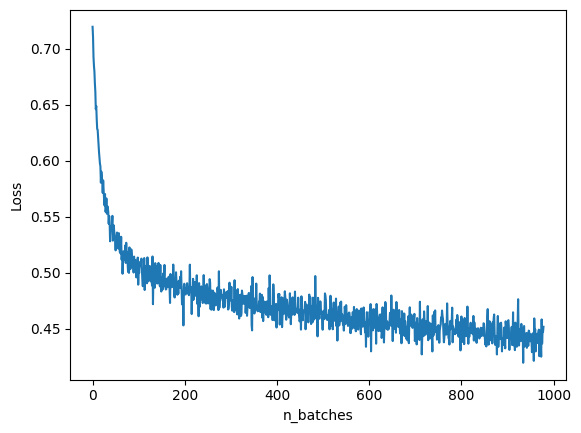

In [11]:
# plot the loss curve
plt.figure();
plt.plot(loss);
plt.xlabel('n_batches');
plt.ylabel('Loss');

## Prediction Generation

##### 1. Compute the cross-validation loss on the subset of the training set based on the optimal hyperparameters

##### Non-neural network models:

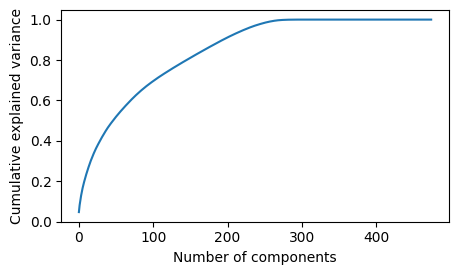

In [14]:
# preprocess the data
NN_METHOD = False
PCA = True
x_train_processed, y_train_processed, _ = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)

In [15]:
# hinge regression
model = lambda x_train, y_train, x_val, y_val : hinge_regression(y_train, x_train, y_val, x_val,
                                                                lambda_=best_params["hinge"]['lamb'], initial_w=np.random.randn(x_train.shape[1]) * 0.01, 
                                                                max_iters=500, gamma=best_params["hinge"]['gamma'], n_pat=20)
f1s_hinge, accs_hinge, losses_hinge, thresholds_hinge = cross_validation(model, x_train_processed, y_train_processed, k_fold=5)
# regularized logistic regression
model = lambda x_train, y_train, x_val, y_val : reg_logistic_regression_var(y_train, add_bias(x_train), y_val, add_bias(x_val),
                                                                lambda_=best_params["reg_log"]['lamb'], initial_w=np.random.randn(x_train.shape[1]+1) * 0.01, 
                                                                max_iters=500, gamma=best_params["reg_log"]['gamma'], n_pat=20)
f1s_reglog, accs_reglog, losses_reglog, thresholds_reglog = cross_validation(model, x_train_processed, y_train_processed, k_fold=5)
# ridge regression
# model = lambda x_train, y_train, x_val, y_val : ridge_regression_var(y_train, add_bias(x_train), y_val, add_bias(x_val), lambda_=best_params["ridge"]['lamb'])
# f1s_ridge, accs_ridge, losses_ridge, thresholds_ridge = cross_validation(model, x_train_processed, y_train_processed, k_fold=5)


Early stopping at iteration  43
Early stopping at iteration  35
Early stopping at iteration  43
Early stopping at iteration  33
Early stopping at iteration  101
Early stopping at iteration  55
Early stopping at iteration  44
Early stopping at iteration  70
Early stopping at iteration  43
Early stopping at iteration  82


In [16]:
# compute the cross-validation score
print("Hinge regression: ")
print("F1 score: {:.3f}".format(np.mean(f1s_hinge)), "+- {:.3f}".format(np.std(f1s_hinge)))
print("Accuracy: {:.3f}".format(np.mean(accs_hinge)), "+- {:.3f}".format(np.std(accs_hinge)))
print("Regularized logistic regression: ")
print("F1 score: {:.3f}".format(np.mean(f1s_reglog)), "+- {:.3f}".format(np.std(f1s_reglog)))
print("Accuracy: {:.3f}".format(np.mean(accs_reglog)), "+- {:.3f}".format(np.std(accs_reglog)))
# print("Ridge regression: ")
# print("F1 score: {:.3f}".format(np.mean(f1s_ridge)), "+- {:.3f}".format(np.std(f1s_ridge)))
# print("Accuracy: {:.3f}".format(np.mean(accs_ridge)), "+- {:.3f}".format(np.std(accs_ridge)))

Hinge regression: 
F1 score: 0.419 +- 0.003
Accuracy: 0.909 +- 0.001
Regularized logistic regression: 
F1 score: 0.421 +- 0.008
Accuracy: 0.910 +- 0.001


##### Neural network model:

In [7]:
NN_METHOD = True
PCA = False
x_train_processed, y_train_processed, x_test_processed = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)

In [8]:
nn_cv = NeuralNetwork([np.shape(x_train_processed)[1], 400, 200, 100, 4, 1],'sigmoid','bce')
model = lambda x_train, y_train, x_val, y_val : nn_cv.train(x_train, y_train, x_val, y_val, learning_rate=0.05, epochs=1000, batch_size=4062)
f1s_nn, accs_nn, losses_nn, thresholds_nn = cross_validation(model, x_train_processed, y_train_processed, k_fold=5, nn_init=nn_cv)

Epoch: 0 Loss: 0.5758574899732233 Validation F1: [0.17458260276681745, 0.2175952618628108, 0.2592787409816814, 0.29829806332195663, 0.3401033618270875, 0.0, 0.0, 0.0, 0.0] Validation Acc: [0.1631892697466468, 0.3786459442197147, 0.5258853168689235, 0.6379071747924207, 0.7463629266907955, 0.9112731530764318, 0.9112731530764318, 0.9112731530764318, 0.9112731530764318]
Epoch: 2 Loss: 0.502192097832296 Validation F1: [0.20973669449096322, 0.25424983138792584, 0.2880901692889369, 0.31842884198062954, 0.3468173371409142, 0.37458978959112904, 0.3889922448958821, 0.0007990409510266127, 0.0] Validation Acc: [0.34019941806827053, 0.5003193527783691, 0.5944574551131928, 0.6662763466042154, 0.7272727272727273, 0.7835852671918245, 0.8369171811794762, 0.9112554112554112, 0.9112731530764318]
Epoch: 4 Loss: 0.4853490349770873 Validation F1: [0.21334024627103587, 0.25933242562879516, 0.29601381568893537, 0.3285997672131739, 0.35955552097952365, 0.39050269416929684, 0.40661330303765514, 0.37468050829275

In [40]:
# compute the cross-validation score
print("Neural Network: ")
print("F1 score: {:.3f}".format(np.mean(f1s_nn)), "+- {:.3f}".format(np.std(f1s_nn)))
print("Accuracy: {:.3f}".format(np.mean(accs_nn)), "+- {:.3f}".format(np.std(accs_nn)))

Neural Network: 
F1 score: 0.410 +- 0.007
Accuracy: 0.909 +- 0.001


#### 2. Train the model on the whole training set with the optimal hyperparameters and predict the labels on the test set

In [33]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("/home/zewzhang/Course/ML/ML_course/projects/project1/data/dataset_to_release", sub_sample=False)

##### Non-neural network models:

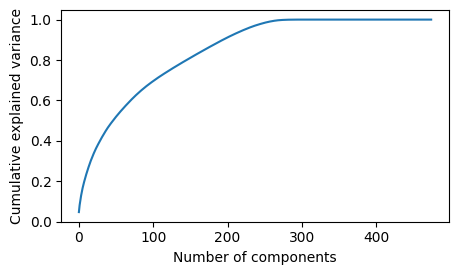

In [12]:
# preprocess the data
NN_METHOD = False
PCA = True
x_train_processed, y_train_processed, x_test_processed = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.9)

In [13]:
# hinge model
w_hinge, _, best_f1_hinge, _, best_threshold_hinge = hinge_regression(y_t, x_t, y_v, x_v, lambda_=best_params["hinge"]['lamb'], 
                                       initial_w=np.random.randn(x_t.shape[1]) * 0.01, max_iters=1000,
                                       gamma=best_params["hinge"]['gamma'], n_pat=30) 
print("Hinge regression: ")
print("F1 score: {:.3f}".format(best_f1_hinge))
y_pred_hinge = predict_labels(w_hinge, x_test_processed, best_threshold_hinge)
create_csv_submission(test_ids, y_pred_hinge, 'hinge.csv')
# regularized logistic regression model
w_reglog, _, best_f1_reg_log, _, best_threshold_reglog = reg_logistic_regression_var(y_t, add_bias(x_t), y_v, add_bias(x_v), lambda_=best_params["reg_log"]['lamb'],
                                                                        initial_w=np.random.randn(x_t.shape[1]+1) * 0.01, max_iters=1000, 
                                                                        gamma=best_params["reg_log"]['gamma'], n_pat=30)
print("Regularized logistic regression: ")
print("F1 score: {:.3f}".format(best_f1_reg_log))
y_pred_reglog = predict_labels(w_reglog, add_bias(x_test_processed), best_threshold_reglog)
create_csv_submission(test_ids, y_pred_reglog, 'reglog.csv')
# ridge regression model
# w_ridge, _, best_f1_ridge, _, best_threshold_ridge = ridge_regression_var(y_t, add_bias(x_t), y_v, add_bias(x_v), lambda_=best_params["ridge"]['lamb'])
# print("Ridge regression: ")
# print("F1 score: {:.3f}".format(best_f1_ridge))
# y_pred_ridge = predict_labels(w_ridge, add_bias(x_test_processed), best_threshold_ridge)
# create_csv_submission(test_ids, y_pred_ridge, 'ridge.csv')

Early stopping at iteration  42
Hinge regression: 
F1 score: 0.390
Early stopping at iteration  39
Regularized logistic regression: 
F1 score: 0.408


##### Nerual network model:

/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


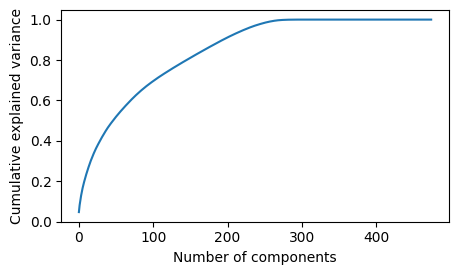

In [47]:
# preprocess the data
NN_METHOD = True
PCA = True
x_train_processed, y_train_processed, x_test_processed = data_processing(x_train, y_train, x_test, row_nan, feature_nan, z_threshold, feature_threshold)
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.8)

In [48]:
nn_final = NeuralNetwork([np.shape(x_t)[1], 400, 200, 100, 4, 1],'sigmoid','bce')
nn_trained_final, _, _, _, best_threshold_nn = nn_final.train(x_t, y_t, x_v, y_v, learning_rate=0.05, epochs=1000, batch_size=4062)
y_pred_nn = nn_final.predict(x_test_processed, best_threshold_nn)
create_csv_submission(test_ids, y_pred_nn, 'nn_PCA.csv')

Epoch: 0 Loss: 0.5277433297327158 Validation F1: [0.08065390952829753, 0.03743938867019722, 0.02076990628167947, 0.013298846887870459, 0.007921534905999067, 0.005328256357704939, 0.0034436565241431245, 0.0023050320417546347, 0.0007698227100138676] Validation Acc: [0.8802781917536016, 0.8978248527428855, 0.9029699808388333, 0.905223192108438, 0.9066780214321198, 0.9072635015257966, 0.9075828543041657, 0.9078489816194735, 0.9078844652615145]
Epoch: 2 Loss: 0.4695229100521396 Validation F1: [0.1953675231098379, 0.1487976189304827, 0.11479899241769079, 0.08369167267978955, 0.0557024346224963, 0.03969409011533435, 0.02533531400436262, 0.015879013303383857, 0.008030591215981039] Validation Acc: [0.8582428500461288, 0.8863281527215954, 0.8968490525867575, 0.9017103115463772, 0.9049570647931303, 0.9064296359378327, 0.9071747924206941, 0.9076360797672273, 0.9079554325455965]
Epoch: 4 Loss: 0.4024736365343089 Validation F1: [0.27175783160893063, 0.24150129111740012, 0.20988278757684167, 0.170643

AttributeError: 'list' object has no attribute 'predict'

In [51]:
y_pred_nn = nn_final.predict(x_test_processed, best_threshold_nn)
create_csv_submission(test_ids, y_pred_nn, 'nn_PCA.csv')